In [1]:
import torch
torch.cuda.is_available()

True

Epoch 1 TrainLoss: 1.1330 TrainAcc: 0.4878
Epoch 1 ValLoss: 1.1546 ValAcc: 0.3780
 
Epoch 2 TrainLoss: 1.0334 TrainAcc: 0.5447
Epoch 2 ValLoss: 1.1004 ValAcc: 0.4512
 
Epoch 3 TrainLoss: 0.9130 TrainAcc: 0.6748
Epoch 3 ValLoss: 1.0622 ValAcc: 0.5122
 
Epoch 4 TrainLoss: 0.8216 TrainAcc: 0.7073
Epoch 4 ValLoss: 0.9430 ValAcc: 0.6463
 
Epoch 5 TrainLoss: 0.7157 TrainAcc: 0.7439
Epoch 5 ValLoss: 0.9166 ValAcc: 0.6341
 
Epoch 6 TrainLoss: 0.6683 TrainAcc: 0.7927
Epoch 6 ValLoss: 0.8115 ValAcc: 0.6829
 
Epoch 7 TrainLoss: 0.5844 TrainAcc: 0.8252
Epoch 7 ValLoss: 0.7778 ValAcc: 0.6951
 
Epoch 8 TrainLoss: 0.4441 TrainAcc: 0.8252
Epoch 8 ValLoss: 0.8039 ValAcc: 0.7073
 
Epoch 9 TrainLoss: 0.3417 TrainAcc: 0.9228
Epoch 9 ValLoss: 0.7387 ValAcc: 0.6829
 
Epoch 10 TrainLoss: 0.3037 TrainAcc: 0.8984
Epoch 10 ValLoss: 0.8369 ValAcc: 0.7439
Saving Model...
Model saved in C:\Users\AKIZUKI\JupyterProjects\AerialPhoto_savedmodel\10\model_weights.pth
 


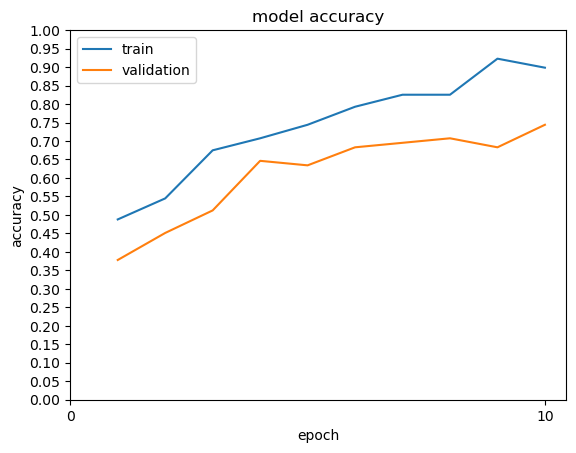

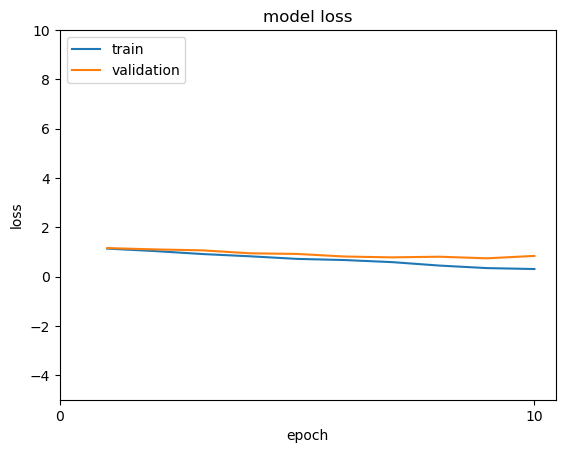

Training Finished!!!


In [4]:
import glob
import os
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms.functional as TF
from torchvision.transforms import v2
import torchvision.models as models
import torch.nn as nn
import cv2
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

Channels=4
batch_size=32
epochs=10
IMG_SIZE=224
valsplit=0.25

Classes = ["higainashi", "houdo", "kanbotsu", "rokatahoukai"]
ClassNum = len(Classes)

trainpath=r"C:\Users\AKIZUKI\JupyterProjects\QGISedited\train"
savepath=r"C:\Users\AKIZUKI\JupyterProjects\AerialPhoto_savedmodel"

'''
PytorchではDataloaderという,膨大なデータセットからでもメモリを圧迫せずに取り出せてforループにも対応するための枠組みがある
データセットをDataloaderが引っ張ってこれるような形式にするためにMyDataset(torch.utils.data.Dataset)というクラスを作れば，
あとはそのメソッドをtorch.utils.data.Datasetが勝手に使用してデータを加工してくれる
__init__, __getitem__, __len__をクラス内で必ず定義しなければならない
Dataloader内のデータはバッチごとにまとめられる
'''
class MyDataset(Dataset):
    def __init__(self, root: str, transforms, Classes) -> None:
        super().__init__()
        self.transforms = transforms
        self.Classes = Classes
        #globは複数のファイルのパスをまとめて取得する
        #訓練と訓練白黒の二個下のディレクトリから画像を取得
        self.data = list(sorted(Path(root).glob("*\*")))
        self.data2 = list(sorted(Path(root+"binary").glob("*\*")))



    # ここで取り出すデータを指定している
    def __getitem__(
            self,
            index: int
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        data = self.data[index]
        data2 = self.data2[index]

        img1 = cv2.imread(str(data))
        img1 = cv2.resize(img1, (IMG_SIZE, IMG_SIZE))
        img2_tmp = cv2.imread(str(data2))

        # グレースケールに変換
        img2_tmp = cv2.cvtColor(img2_tmp,cv2.COLOR_BGR2GRAY)
        # 2値化
        ret,img2 = cv2.threshold(img2_tmp, 0, 255, cv2.THRESH_BINARY_INV)
        img2 = cv2.resize(img2, (IMG_SIZE, IMG_SIZE))

        #img1のテンソルとimg2のテンソルをチャンネル方向(dim0)に結合
        cat_img = torch.cat((TF.to_tensor(img1), TF.to_tensor(img2)), dim=0)

        # データの変形 (transforms)
        transformed_img = self.transforms(cat_img)

        #ラベル貼り：dataというパスを/で区切ってリストにし，クラス名のところをラベルに格納
        #クラス名は文字列なので，self.Classesの要素と比較して一致するところの番号をラベルとする
        label = str(data).split("\\")[-2]
        label = torch.tensor(self.Classes.index(label))

        return transformed_img, label

    # この method がないと DataLoader を呼び出す際にエラーを吐かれる
    def __len__(self) -> int:
        return len(self.data)


#入力データに施す処理
transforms = v2.Compose([
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0,0,0,0], std=[0.2, 0.2, 0.2, 0.2]),
])


trainvalset = MyDataset(root=trainpath, transforms=transforms, Classes=Classes)
trainset, valset = random_split(trainvalset, [1-valsplit, valsplit])

trainloader = DataLoader(dataset=trainset,batch_size=batch_size,shuffle=True)
valloader = DataLoader(dataset=valset,batch_size=batch_size,shuffle=True)


resnet50 = models.resnet50(weights=True)

#modify first layer so it expects 4 input channels; all other parameters unchanged
resnet50.conv1 = torch.nn.Conv2d(Channels,64,kernel_size = (7,7),stride = (2,2), padding = (3,3), bias = False)
#modifying final layer
resnet50.fc = nn.Linear(2048,ClassNum)

#GPUにニューラルネットワークを渡す
resnet50=resnet50.to(device)

#lossfunction&optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

'''
trainiterator
enumerateはtrainloader内のすべてのdataに対してループし，繰り返し回数をbatchに渡すという意味
Dataloader内ではバッチごとにデータがまとめられるので1回の取り出しで1バッチ分のデータを丸々取り出せる
'''
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train(trainloader, valloader, model, loss_fn, optimizer, epochs):
    size = len(trainloader.dataset)
    num_batches = len(trainloader)
    size_val = len(valloader.dataset)
    num_batches_val = len(valloader)
    for epoch in range(epochs):
        running_loss, running_correct = 0, 0
        val_loss, val_correct = 0, 0
        for batch, (X, y) in enumerate(trainloader):
            X=X.to(device)
            y=y.to(device)
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            #損失と正解数の合計を計算しておき，後でそのエポック内での平均をとる
            running_loss += loss.item()
            running_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        epoch_loss = running_loss / num_batches
        epoch_acc = running_correct / size

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch + 1} TrainLoss: {epoch_loss:.4f} TrainAcc: {epoch_acc:.4f}')

        # Set the model to evaluation mode - important for batch normalization and dropout layers
        model.eval()
        # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
        # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
        with torch.no_grad():
            for X, y in valloader:
                X=X.to(device)
                y=y.to(device)
                pred = model(X)
                val_loss += loss_fn(pred, y).item()
                val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            val_loss /= num_batches_val
            val_correct /= size_val
        # Set the model to train mode
        model.train()

        val_losses.append(val_loss)
        val_accuracies.append(val_correct)

        print(f'Epoch {epoch + 1} ValLoss: {val_loss:.4f} ValAcc: {val_correct:.4f}')

        #10epoch毎にパラメータを別々のフォルダに保存
        e1=epoch+1
        if (e1 % 10 == 0):
            savepath2 = Path(savepath+"\\"+str(e1)+"\model_weights.pth")
            print('Saving Model...')
            torch.save(model.state_dict(), savepath2)
            print('Model saved in', savepath2)

        print(' ')

train(trainloader, valloader, resnet50, loss_fn, optimizer, epochs)

#グラフ可視化
#pltの(x,y)のxにあたるepochのリスト　1から開始
ep=np.arange(1, epochs+1)

def plot_acc(train_accuracies, val_accuracies):
    plt.plot(ep, train_accuracies)
    plt.plot(ep, val_accuracies)
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.xticks(np.arange(0, epochs+1, 10))
    plt.yticks(np.arange(0.0, 1.05, 0.05))
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

def plot_loss(train_losses, val_losses):
    plt.plot(ep, train_losses)
    plt.plot(ep, val_losses)
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.xticks(np.arange(0, epochs+1, 10))
    plt.ylim(bottom=-5, top=10)
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_acc(train_accuracies, val_accuracies)
plot_loss(train_losses, val_losses)

print('Training Finished!!!')